# Ungraded Lab - Deploy a Machine Learning Model

Welcome to this ungraded lab! If you are reading this it means you did the setup properly, nice work!

In this lab you will see what deploying a real machine learning model feels like. To be more concrete, you will deploy a computer vision model that detects the number of cars in a picture. Usually deploying a model is one of the last steps involving the machine learning lifecycle but we thought it would be exciting to get to deploy a model right away. With this in mind you will be using a pretrained model called [`YOLOV3`](https://pjreddie.com/darknet/yolo/). This model is really fast and yields accurate results for the task of object detection.

First you will look at the model itself and then you will use [`fastAPI`](https://fastapi.tiangolo.com/) to deploy it.

## YOLOV3

### Inspect the images

Before checking the model let's take a look at some images of common objects that YOLOV3 is able to detect.

In [1]:
from IPython.display import Image, display

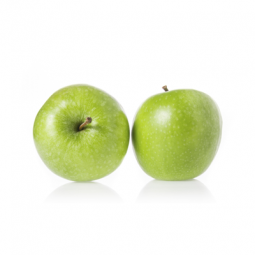

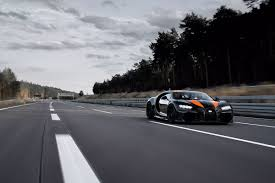

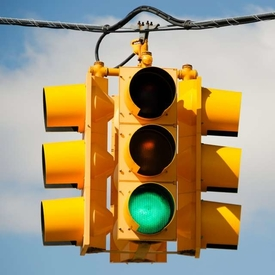

In [2]:
# Some example images
image_files = [
    'apples.jpg',
    'car1.jpeg',
    'traffic_light.jpg']

for image_file in image_files:
    display(Image(filename=f"images/{image_file}"))

### Overview of the model

Now that you know how the images look like, let's try and see if the model is able to detect and classify them correctly.

For this you will be using [`cvlib`](https://www.cvlib.net/), which is a very simple but powerful library for object detection that is fueled by [`OpenCV`](https://docs.opencv.org/4.5.1/) and [`Tensorflow`](https://www.tensorflow.org/).

In concrete you will use the [`detect_common_objects`](https://docs.cvlib.net/object_detection/) function, which given an image represented as a [`numpy array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) returns:

- `bbox`: list of list containing bounding box co-ordinates for detected objects. 

        Example:
    
    ```python
        [[32, 76, 128, 192], [130, 83, 220, 185]]
    ```

- `label`: list of labels for detected objects.
    
        Example:
    ```python
        ['apple', 'apple']
    ```


- `conf`: list of confidence scores for detected objects.
        Example:
    ```python
        [0.6187325716018677, 0.42835739254951477]
    ```

### Create detect_and_draw_box function

Let's define the `detect_and_draw_box` function which, given a **filename** of a file on your system, a **model** and a **confidence level**, detects common objects in the image and saves a new image displaying the bounding boxes alongside the detected object.

You might ask yourself why does this function receive the model as a parameter? What models are there to choose from?

The answer is that `detect_common_objects` uses the `yolov3` model by default but another much tinier version of it can also be selected. 

This model is known as `yolov3-tiny`. It is designed for constrained environments that cannot store big models and as a result of this, it presents the tradeoff that it yields less accuracy than the full version. However, it still works pretty well. Going forward we recommend you stick to it since it is a lot smaller than the regular `yolov3` and downloading its pretrained weights takes a lot less time. But if your internet is good we recommend to also try out the default version.

In [3]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Print current image's filename
    print(f"Image being processed: {filename}\n")
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Let's try it out for the example images.

Image being processed: apples.jpg



Detected object: apple with confidence level of 0.6187325716018677



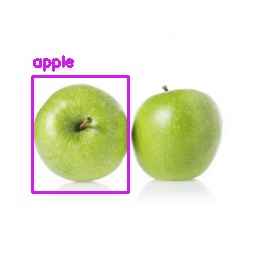

Image being processed: car1.jpeg

Detected object: car with confidence level of 0.9725152254104614



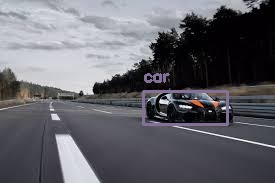

Image being processed: traffic_light.jpg

Detected object: traffic light with confidence level of 0.8180173635482788



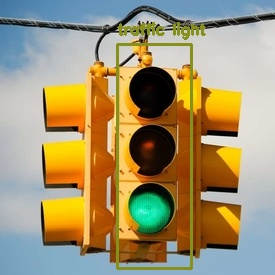

In [4]:
for image_file in image_files:
    detect_and_draw_box(image_file)

## Changing the confidence level

Looks like the object detection went fairly well. However, the **model failed to detect** the second apple for the image containing the two apples. This might seem strange since it was able to detect one apple so one might think it knows how an apple looks like.

What probably happened is that the model **did** detect the apple but with a confidence level lower than 0.5. Let's test this hypothesis:

Image being processed: apples.jpg

Detected object: apple with confidence level of 0.6187325716018677

Detected object: apple with confidence level of 0.42835739254951477



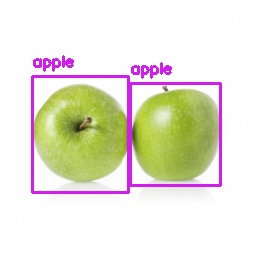

In [5]:
detect_and_draw_box("apples.jpg", confidence=0.4)

By lowering the confidence level the model successfully detects the two apples.

## Deploying the model using fastAPI


### A concrete task - Count number of cars in an image

Now that you know how the model works it is time for you to deploy it! Aren't you excited? :)

Models in production usually perform a specific task. For this case let's suppose that the company you work at, has given you the task to deploy a model responsible for reporting the number of cars in a given image. Given what you already know, let's see how you can leverage `fastAPI` to create a server that will carry out this.


### Some concept clarifications

#### Client-Server model

When talking about **deploying**, what is usually meant is to put all of the software required for predicting in a `server`. By doing this, a `client` can interact with the model by sending `requests` to the server. 

This client-server interaction is out of the scope of this notebook but there are a lot of resources that you can use to understand it better. Just type `client server` in the search engine of your choice and you will get a lot of results.

The important things you need to understand is that the Machine Learning model lives in a server waiting for some client to ask it to return predictions. The client should provide the information (values for the features or even images) that the model needs in order to make a prediction or predictions (it is common to batch many predictions in a single request). After using this information to predict, the server will return the actual prediction to the client, who can use it in any desired way.

#### Endpoints

You can host multiple Machine Learning models in the same server. For this to work you can assign a different `endpoint` to each model so you always know what model is being used. An endpoint is represented by a pattern in the `URL`. As an example if you have a website called `myawesomemodel.com` you could have three different models in the following endpoints:

- `myawesomemodel.com/count-cars/`
- `myawesomemodel.com/count-apples/`
- `myawesomemodel.com/count-plants/`

Each model would do what the pattern suggests.

#### HTTP Requests

If you are wondering how the client and the server manage to communicate with each other the answer is through a protocol called `HTTP`. You can research more on your own if you are not familiar with this concept but the important concept to understand is that this communication between client and server uses some verbs to denote common actions. Two very common of these such verbs are:

- `GET`
- `POST`

If your client does a `GET request` to an endpoint of a server you will get some information from this endpoint without the need to provide additional information. In the case of a `POST request` you are explicitly telling the server that you will provide some information for it that must be processed in some way.

Interactions with Machine Learning models living on endpoints are usually done via a `POST request` since you need to provide the information that the prediction is gonna be computed for.


### Why fastAPI?

The reason that you are doing this exercise using fastAPI is that it enables to create web servers to host your models very easily. Aditional to this, it is extremely fast and it has a built-in client that can be used to interact with the server. Isn't that convenient?

Enough chatter, let's get going!

In [6]:
import io
import uvicorn
import nest_asyncio
import numpy as np
from enum import Enum
from fastapi import FastAPI, UploadFile, File

In [7]:

description = """<h2>Run the Image Detector by uploading an image in the `predict/image` endpoint</h2>"""

app = FastAPI(title='Deploying a ML Model with FastAPI', description=description)

## Body Parameters
class PretrainedWeights(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"

@app.get("/")
def home():
    return "GET method works! Now test the predict endpoint by opening the API docs and uploading an image"

@app.post("/predict/") 
def prediction(pretrainedWeights: PretrainedWeights, file: UploadFile = File(...)):

    ## Input Validation Step
    fileExtension = file.filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        return "Image must be in jpg or png format!"
    
    ## Transform Raw Image to CV2 Image
    image_stream = io.BytesIO(file.file.read())
    image_stream.seek(0)
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

    ## Run Object Detector (YOLOv3 pretrained on the COCO Dataset)
    _, label, conf = cv.detect_common_objects(image, nms_thresh = 0.3, confidence=0.5, model=pretrainedWeights)
    
    ## Print returned objects and confidence levels
    print("label", label)
    print("conf", conf)
   
    ## Return number of cars in the image
    num_cars = label.count('car')
    print('Number of cars in the image is '+ str(num_cars))
    return {"num_cars":num_cars}


In [9]:
nest_asyncio.apply()
uvicorn.run(app, host="0.0.0.0", port=8000)

INFO:     Started server process [30]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     172.17.0.1:53520 - "GET / HTTP/1.1" 200 OK
INFO:     172.17.0.1:53520 - "GET /docs HTTP/1.1" 200 OK
INFO:     172.17.0.1:53520 - "GET /openapi.json HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [30]
